In [3]:
%run ../modules/qpca

In [4]:
from sklearn import datasets
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

We load the iris dataset and compute its covariance matrix

In [5]:
dataset = datasets.load_iris()
x=dataset.data
y=dataset.target

#Center the dataset s.t. the mean is 0 for each feature
means = np.mean(x,axis=0)
u=np.ones(len(x))[None] 
u=u.reshape((len(x),1)) 
means=means.reshape((len(x[0]),1))
centered = x-np.dot(u,means.T)

#Compute the covariance matrix
covariance_matrix=(1/(len(x)-1)) * np.dot(np.transpose(np.conj(centered)), centered)
covariance_matrix = covariance_matrix/np.trace(covariance_matrix)

For reference, we compute the eigendecomposition classically. We can then identify the first 2 principal components and project the dataset onto this new feature space.

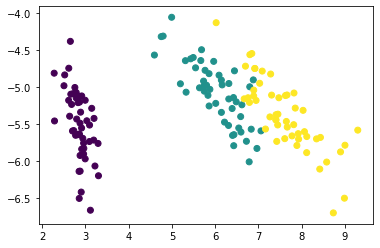

In [6]:
#compute the eigenvectors and eigenvalues
eigval, eigvec = np.linalg.eig(covariance_matrix)

#order them by eigenvalue
eva=eigval[np.argsort(eigval)[::-1]]
evs=eigvec[:,np.argsort(eigval)[::-1]]

#new feature space given by the first 2 pc
tranformation_matrix=np.array([evs[:,0],evs[:,1]])

result=np.dot(x, tranformation_matrix.T)
plt.scatter(result.T[0],result.T[1], c=y)
plt.show()

Now we will try to replicate these results with our Quantum Algorithm.<br>
The initial vector to be given as input to the algorithm was randomly generated.<br>
The number of qubits that determines the estimation precision of the eigenvalues is set to 4.

In [7]:
covariance_matrix = covariance_matrix/np.trace(covariance_matrix)

#random vector obtained by np.random.rand(4)*2-1
initial = [-0.90454731, -0.66289814, -0.32369894,  0.45179635]

res = qpca(covariance_matrix, 4, initialeig=initial)

The histogram shows the eigenvalues found by the algorithm and how often they were measured.<br>

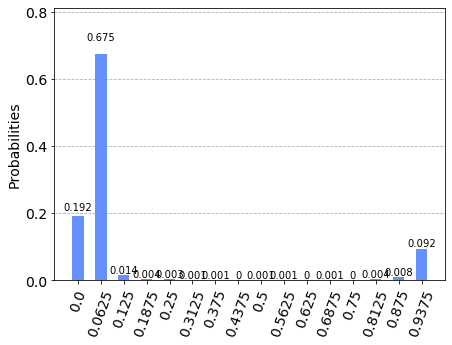

In [8]:
plot_histogram(res.get_eigvals(False))

We are interested in the eigenvectors corresponding to the largest eigenvalues. That is, $0.9375$ and $0.0625$.

In [9]:
pc1 = res.eigvec_from_eigval(0.9375)[0]
pc2 = res.eigvec_from_eigval(0.0625)[0]

print("PC1:",pc1)
print("PC2:",pc2)

PC1: [ 0.28044908 -0.22485951  0.88685785  0.29029237]
PC2: [ 0.66397305  0.72463067 -0.15380479 -0.10195227]


Once again, we can now plot the data in the new feature space.

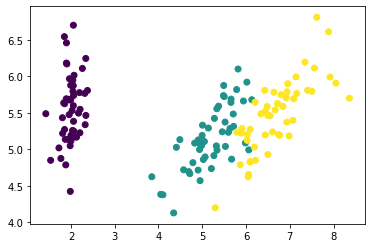

In [10]:
tranformation_matrix=np.array([pc1,pc2])
result=np.dot(x, tranformation_matrix.T)

plt.scatter(result.T[0],result.T[1], c=y)
plt.show()

From this graph we can see that the PC2 found by the quantum algorithm is the inverse of the one found by the classical algorithm.<br>
Simply inverting the $y$-axis gets us closer to our reference.

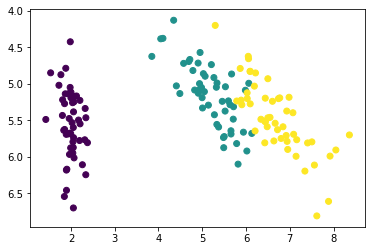

In [11]:
plt.scatter(result.T[0],result.T[1], c=y)
plt.gca().invert_yaxis()
plt.show()

Looking again at the measurements histogram, we notice that there are only 3 peaks signalling the presence of eigenvalues (at $0.0$, $0.0625$ and $0.9375$) while we expect to compute 4 different eigenvalues for the $4x4$ covariance matrix.<br>
The true classically computed eigenvalues are the following

In [12]:
print(eva)

[0.92461872 0.05306648 0.01710261 0.00521218]


Clearly, given the choice of 4 bits precision, we obtain the best approximations for $0.9246$ at $0.9375$ and for $0.0530$ at $0.0625$, while $0.0171$ and $0.0052$ cannot be distinguished and both contribute to generate the peak at $0.0$